In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

tqdm.pandas()

# CUDAのデバッグ用
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 (本番用) ---

TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"
MODEL_CHECKPOINT = "allenai/longformer-base-4096"
OUTPUT_MODEL_DIR = "models/cencoder_margin_v1" # 本番用の保存先

# --- 実験計画からのハイパーパラメータ ---
MAX_LENGTH = 2048
LEARNING_RATE = 2e-5
MARGIN_RANKING_MARGIN = 1.0
EPOCHS = 3       # ▼▼▼ 3エポックで実験 ▼▼▼
BATCH_SIZE = 16  # ▼▼▼ バッチサイズ16 ▼▼▼
GRAD_ACCUM_STEPS = 4 # ▼▼▼ 勾配累積4 (実質バッチ 16*4=64) ▼▼▼

print(f"Configuration set for PRODUCTION (Batch Size: {BATCH_SIZE}, Grad Accum: {GRAD_ACCUM_STEPS}, Epochs: {EPOCHS})")

Configuration set for PRODUCTION (Batch Size: 16, Grad Accum: 4, Epochs: 3)


In [3]:
# --- 3. カスタムモデルクラスの定義 ---

class CrossEncoderMarginModel(BertPreTrainedModel):
    """
    C-Encoder (Margin) モデル
    内部で C-Encoder (BCE) と同じモデルを2回呼び出す
    """
    def __init__(self, config):
        super(CrossEncoderMarginModel, self).__init__(config)
        # Longformerベースのスコア計算機 (num_labels=1)
        self.scorer = AutoModelForSequenceClassification.from_config(config)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_neg=None,
        attention_mask_neg=None,
        labels=None, 
        **kwargs
    ):
        # 1. ポジティブペアのスコアを計算 (入力: (Anchor, Positive))
        output_pos = self.scorer(input_ids=input_ids, attention_mask=attention_mask)
        score_positive = output_pos.logits

        # 2. ネガティブペアのスコアを計算 (入力: (Anchor, Negative))
        output_neg = self.scorer(input_ids=input_ids_neg, attention_mask=attention_mask_neg)
        score_negative = output_neg.logits

        return SequenceClassifierOutput(
            loss=None,
            logits=(score_positive, score_negative),
            hidden_states=None,
            attentions=None,
        )

print("Custom model class 'CrossEncoderMarginModel' defined.")

Custom model class 'CrossEncoderMarginModel' defined.


In [4]:
# --- 4. データセットの読み込みとTripletへの変換 ---
print(f"Loading full dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df_full['label'] = df_full['label'].astype(int)
print(f"Full dataset size: {len(df_full)}")

# 全データセットを正例ペアと負例ペアに分割
pos_df = df_full[df_full['label'] == 1]
neg_df = df_full[df_full['label'] == 0]

if pos_df.empty or neg_df.empty:
    raise ValueError("Full dataset must contain both positive and negative samples.")

# --- Tripletの作成 (Anchor, Positive, Negative) ---
print("Creating triplets from full dataset...")
triplets = []
negative_abstracts = neg_df['abstract_b'].tolist()

for index, row in tqdm(pos_df.iterrows(), total=len(pos_df), desc="Creating Triplets"):
    anchor = row['abstract_a']
    positive = row['abstract_b']
    negative = np.random.choice(negative_abstracts)
    
    triplets.append({
        'anchor': anchor,
        'positive': positive,
        'negative': negative
    })

df_triplets = pd.DataFrame(triplets)
df_triplets['labels'] = 0 # ダミーのlabels列
print(f"Created {len(df_triplets)} triplets.")

raw_dataset = Dataset.from_pandas(df_triplets)
# 本番なので、検証データ(validation)も多め(20%)に確保
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Triplet dataset loaded: {dataset}")

Loading full dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Full dataset size: 34624
Creating triplets from full dataset...


Creating Triplets:   0%|          | 0/7013 [00:00<?, ?it/s]

Created 7013 triplets.
Triplet dataset loaded: DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 5610
    })
    validation: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 1403
    })
})


In [5]:
# --- 5. トークナイズ処理 ---
print("Initializing Longformer tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_cencoder_margin_function(examples):
    # (Anchor, Positive) ペアをトークン化
    tokenized_pos = tokenizer(
        examples["anchor"], examples["positive"], 
        padding="max_length", truncation=True, max_length=MAX_LENGTH
    )
    # (Anchor, Negative) ペアをトークン化
    tokenized_neg = tokenizer(
        examples["anchor"], examples["negative"], 
        padding="max_length", truncation=True, max_length=MAX_LENGTH
    )
    
    return {
        "input_ids": tokenized_pos["input_ids"],
        "attention_mask": tokenized_pos["attention_mask"],
        "input_ids_neg": tokenized_neg["input_ids"],
        "attention_mask_neg": tokenized_neg["attention_mask"],
    }

print("Tokenizing C-Encoder Margin dataset...")
tokenized_datasets = dataset.map(tokenize_cencoder_margin_function, batched=True, num_proc=4,
                                 remove_columns=["anchor", "positive", "negative"])
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Initializing Longformer tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing C-Encoder Margin dataset...


Map (num_proc=4):   0%|          | 0/5610 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1403 [00:00<?, ? examples/s]

Tokenization complete.


In [6]:
# --- 6. カスタムTrainerの定義 ---

class MarginRankingTrainer(Trainer):
    def __init__(self, *args, margin=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.margin = margin
        self.loss_fct = nn.MarginRankingLoss(margin=self.margin)
        print(f"MarginRankingTrainer initialized with margin={self.margin}")

    def compute_loss(self, model, inputs, return_outputs=False):
        if "labels" in inputs:
            inputs.pop("labels")
            
        outputs = model(**inputs)
        score_positive, score_negative = outputs.logits
        
        # ターゲット 'y' は 1 を設定
        target = torch.ones_like(score_positive)
        loss = self.loss_fct(score_positive, score_negative, target)

        return (loss, outputs) if return_outputs else loss

print("Custom 'MarginRankingTrainer' defined.")

Custom 'MarginRankingTrainer' defined.


In [7]:
# --- 7. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
# ★num_labels=1★ でロード (スコア計算機として)
model = CrossEncoderMarginModel.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=1 
).to(device)
print("Custom model loaded.")

# 評価指標を計算する関数
def compute_metrics_margin(eval_pred):
    score_pos, score_neg = eval_pred.predictions
    preds = (score_pos.squeeze() > score_neg.squeeze())
    accuracy = preds.mean().item()
    return {'rank_accuracy': accuracy}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, # 16
    per_device_eval_batch_size=BATCH_SIZE, # 16
    gradient_accumulation_steps=GRAD_ACCUM_STEPS, # 4
    num_train_epochs=EPOCHS, # 3
    weight_decay=0.01,
    evaluation_strategy="epoch", # エポックごとに評価
    save_strategy="epoch",       # エポックごとに保存
    load_best_model_at_end=True, # 最高のモデルを最後にロード
    logging_strategy="steps",
    logging_steps=100,           # 100ステップごとにログ表示
    warmup_ratio=0.1,            # 10%ウォームアップ
    gradient_checkpointing=True, # メモリ節約
)
print("Training arguments set for PRODUCTION.")

Loading custom model: allenai/longformer-base-4096


You are using a model of type longformer to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of CrossEncoderMarginModel were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['scorer.bert.embeddings.LayerNorm.bias', 'scorer.bert.embeddings.LayerNorm.weight', 'scorer.bert.embeddings.position_embeddings.weight', 'scorer.bert.embeddings.token_type_embeddings.weight', 'scorer.bert.embeddings.word_embeddings.weight', 'scorer.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'scorer.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'scorer.bert.encoder.layer.0.attention.output.dense.bias', 'scorer.bert.encoder.layer.0.attention.output.dense.weight', 'scorer.bert.encoder.layer.0.attention.self.key.bias', 'scorer.bert.encoder.layer.0.attention.self.key.weight', 'scorer.bert.encoder.layer.0.attention.self.query.bias', 'scorer.bert.encoder.layer.0.attention.s

Custom model loaded.
Training arguments set for PRODUCTION.


In [8]:
# --- 8. 訓練の開始 ---
trainer = MarginRankingTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_margin,
    margin=MARGIN_RANKING_MARGIN
)

print("\n--- Starting Model Training (C-Encoder Margin PRODUCTION) ---")
trainer.train()
print("--- Model Training Complete ---")

MarginRankingTrainer initialized with margin=1.0

--- Starting Model Training (C-Encoder Margin PRODUCTION) ---


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rank Accuracy
0,No log,0.125642,0.958660
1,0.615400,0.068991,0.977904
2,0.094100,0.059265,0.976479


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


--- Model Training Complete ---


In [9]:
# --- 9. モデルの保存 ---
print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path}")

Training complete. Saving best model...
Model saved to models/cencoder_margin_v1/best_model



--- Visualizing Training Results ---


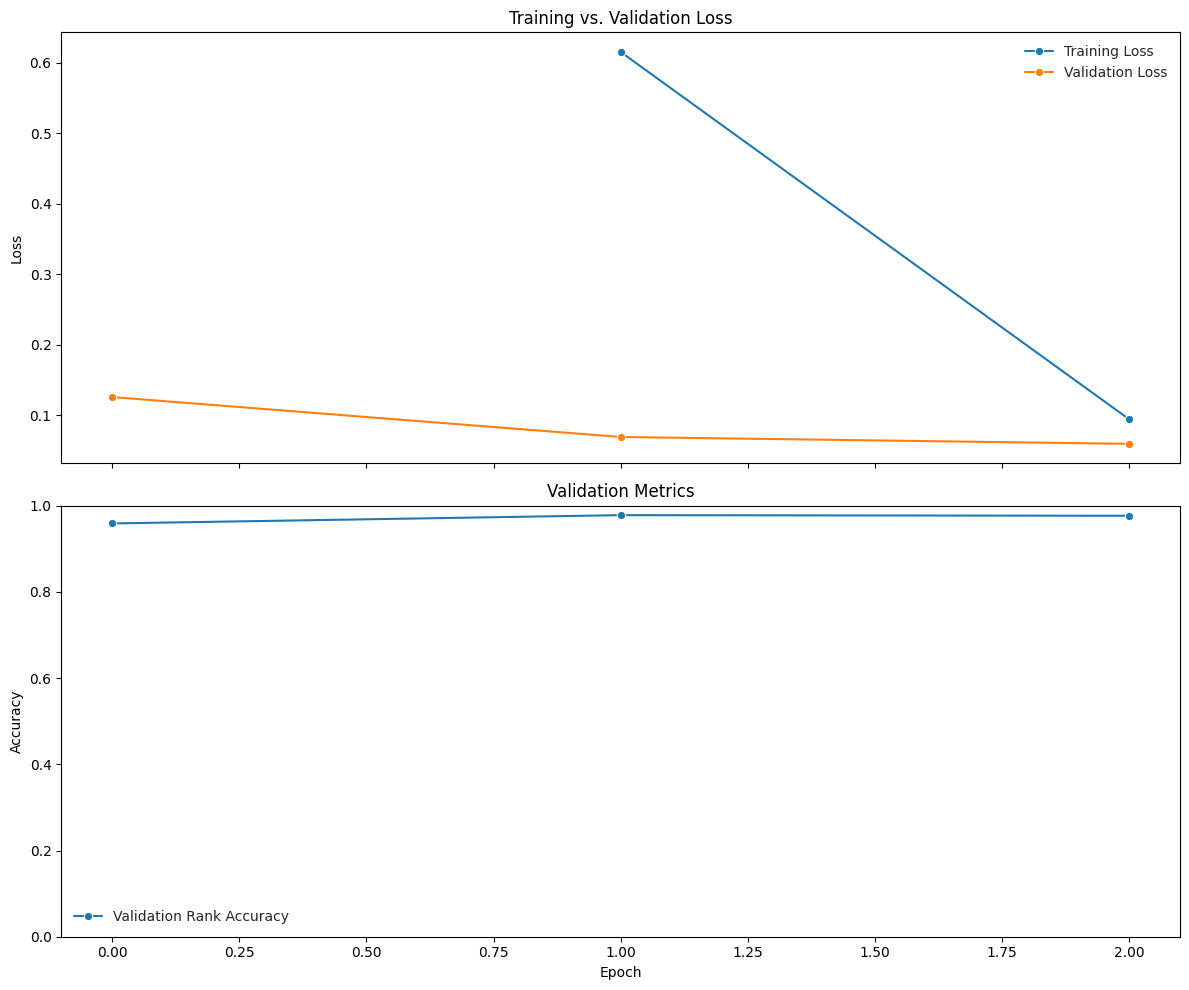


--- Best Model Evaluation Metrics (from validation set) ---
Best Epoch (based on min eval_loss): 2.0
Best Validation Loss: 0.0593
Best Validation Rank Accuracy: 0.9765


In [10]:
# --- 10. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

if 'epoch' in df_train.columns:
    df_train['epoch'] = df_train['epoch'].astype(int)
if 'epoch' in df_eval.columns:
    df_eval['epoch'] = df_eval['epoch'].astype(int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='epoch', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_rank_accuracy', label='Validation Rank Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Epoch (based on min eval_loss): {best_run['epoch']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation Rank Accuracy: {best_run['eval_rank_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")